# Malaria Detection

Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable. 

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler


import os
print(os.listdir("/Users/tarunreddy/Desktop/codes/DL project/cell_images"))

['malaria_detection.pt', '.DS_Store', 'Parasitized', 'Uninfected']


In [2]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

## Dataset

In [3]:
img_dir='/Users/tarunreddy/Desktop/codes/DL project/cell_images'
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(len(valid_idx), len(test_idx), len(train_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=20, 
    sampler=test_sampler, num_workers=num_workers)

5511 2756 19291


## Model ResNet50

In [5]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 2, bias=True)

fc_parameters = model.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True
    
model

/Users/tarunreddy/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tarunreddy/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001 , momentum=0.9)

## Training The Network

In [7]:
def train(n_epochs, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))


        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [8]:
train(5, model, optimizer, criterion, use_cuda, 'malaria_detection.pt')

Epoch 1, Batch 1 loss: 0.698319
Epoch 1, Batch 101 loss: 0.531216
Epoch 1, Batch 201 loss: 0.475513
Epoch 1, Batch 301 loss: 0.454828
Epoch: 1 	Training Loss: 0.454768 	Validation Loss: 0.394035
Validation loss decreased (inf --> 0.394035).  Saving model ...
Epoch 2, Batch 1 loss: 0.379061
Epoch 2, Batch 101 loss: 0.403077
Epoch 2, Batch 201 loss: 0.398230
Epoch 2, Batch 301 loss: 0.391449
Epoch: 2 	Training Loss: 0.391559 	Validation Loss: 0.368126
Validation loss decreased (0.394035 --> 0.368126).  Saving model ...
Epoch 3, Batch 1 loss: 0.339958
Epoch 3, Batch 101 loss: 0.383107
Epoch 3, Batch 201 loss: 0.382978
Epoch 3, Batch 301 loss: 0.379089
Epoch: 3 	Training Loss: 0.378585 	Validation Loss: 0.353903
Validation loss decreased (0.368126 --> 0.353903).  Saving model ...
Epoch 4, Batch 1 loss: 0.414547
Epoch 4, Batch 101 loss: 0.374717
Epoch 4, Batch 201 loss: 0.376001
Epoch 4, Batch 301 loss: 0.374621
Epoch: 4 	Training Loss: 0.375292 	Validation Loss: 0.371275
Epoch 5, Batch 1 l

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Loading Saved Model

In [9]:
model.load_state_dict(torch.load('malaria_detection.pt'))

<All keys matched successfully>

## Testing The Model

In [10]:
def test(model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
test(model, criterion, use_cuda)

Test Loss: 0.332952


Test Accuracy: 85% (2350/2756)


In [11]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [12]:
def predict_malaria(model, class_names, img_path):
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

Parasitized


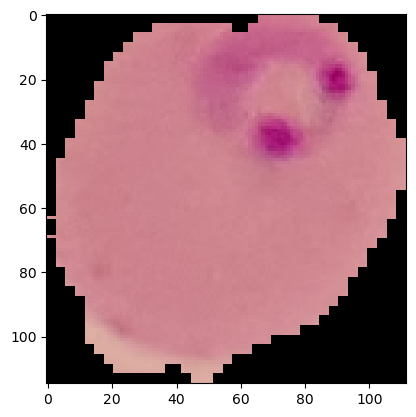

Parasitized


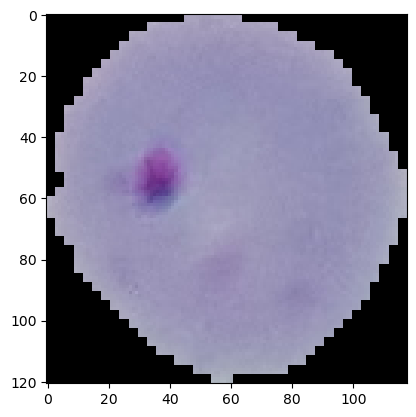

Parasitized


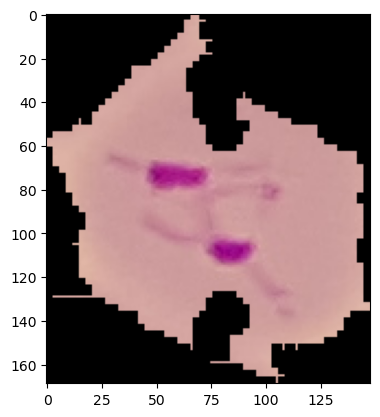

Parasitized


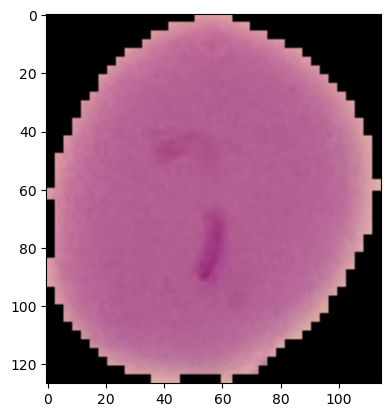

Uninfected


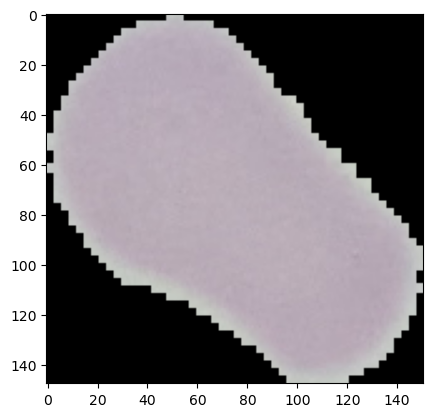

Uninfected


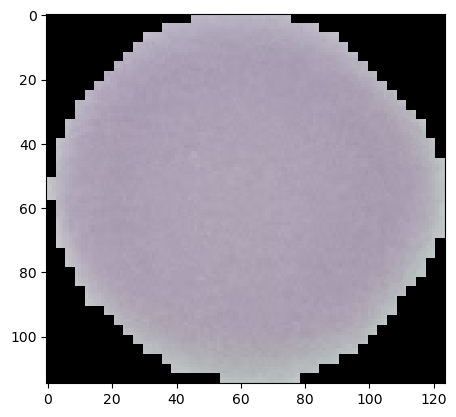

In [13]:
from glob import glob
import numpy as np
from PIL import Image
from termcolor import colored

class_names=['Parasitized','Uninfected']
inf = np.array(glob("/Users/tarunreddy/Desktop/codes/DL project/Parasitized/*"))
uninf = np.array(glob("/Users/tarunreddy/Desktop/codes/DL project/Uninfected/*"))
for i in range(3):
    img_path=inf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
    plt.imshow(img)
    plt.show()
for i in range(3):
    img_path=uninf[i]
    img = Image.open(img_path)
    if predict_malaria(model, class_names, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))        
    plt.imshow(img)
    plt.show()

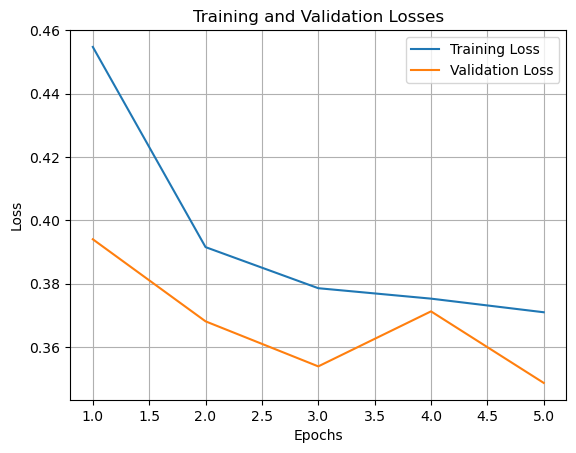

In [16]:
import matplotlib.pyplot as plt

# Provided training and validation losses
train_losses = [0.454768, 0.391559, 0.378585, 0.375292, 0.370992]
valid_losses = [0.394035, 0.368126, 0.353903, 0.371275, 0.348681]

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

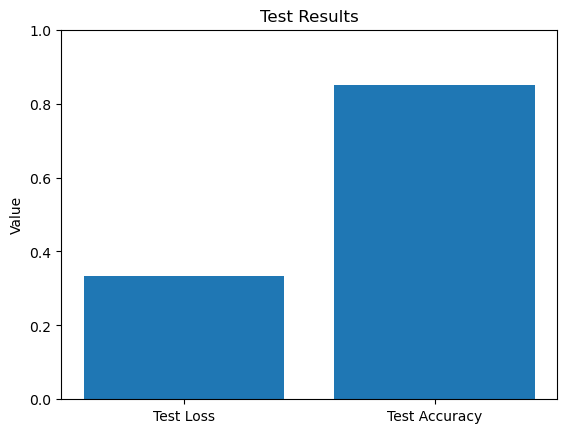

In [19]:
import matplotlib.pyplot as plt

def plot_test_results(test_loss, test_accuracy):
    # Create a bar plot for test loss and accuracy
    plt.bar(['Test Loss', 'Test Accuracy'], [test_loss, test_accuracy])
    plt.ylabel('Value')
    plt.title('Test Results')
    plt.ylim(0, 1.0)  # Assuming test loss and accuracy values are between 0 and 1
    plt.show()

# Example test results
test_loss = 0.332952
test_accuracy = 0.85

# Plot test results
plot_test_results(test_loss, test_accuracy)


In [23]:
def calculate_metrics(model, criterion, use_cuda):
    # initialize lists to store true and predicted labels
    y_true = []
    y_pred = []

    # set the model to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        # append true and predicted labels to lists
        y_true.extend(target.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

    # calculate precision, recall, and F1 score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score: ", f1)

calculate_metrics(model, criterion, use_cuda)

Precision:  0.8393680052666228
Recall:  0.9029745042492918
F1 score:  0.8700102354145343


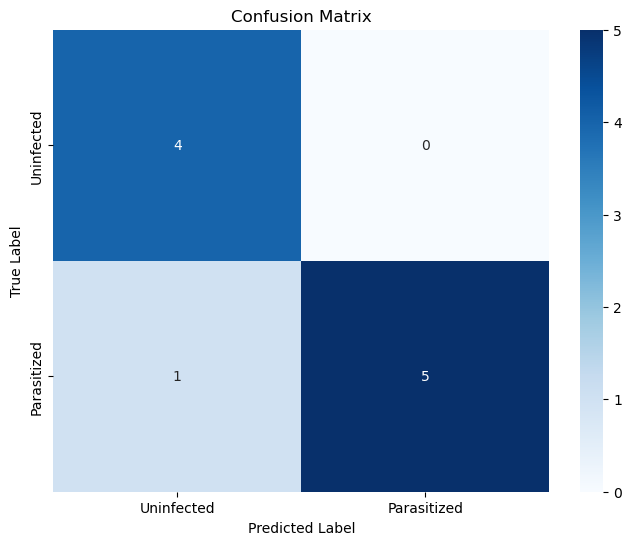

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example true labels and predicted labels obtained from model evaluation
true_labels = [1, 0, 1, 1, 0, 1, 0, 0, 1, 1]  # Example true labels (1: Parasitized, 0: Uninfected)
predicted_labels = [1, 0, 1, 1, 0, 1, 0, 0, 0, 1]  # Example predicted labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
